<a href="https://colab.research.google.com/github/LeoneedDev/animal_classification/blob/feat%2Fdata_preprocessing_and_split/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from dataset.translate import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
import wandb

# Import data

In [21]:
def translate_label(dirname: str, mapping: dict[str, str]) -> str:
    translated = mapping.get(dirname, dirname)
    return translated

In [22]:
df = pd.DataFrame()
data = []

for (dirpath, dirnames, filenames) in os.walk("./dataset/raw-img"):
    if filenames:
        label = os.path.basename(dirpath)
        translated_label = translate_label(label, translate_it_to_en)
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            data.append({'label': translated_label, 'filepath': filepath})

df = pd.DataFrame(data)
df

,label,filepath
0,horse,./dataset/raw-img/cavallo/OIP-w_u9gdSBzD9Lowb8...
1,horse,./dataset/raw-img/cavallo/OIP-wGq4cqbM8pFPMIt6...
2,horse,./dataset/raw-img/cavallo/OIP-TjdFpcKrHgjXocTY...
3,horse,./dataset/raw-img/cavallo/OIP-f7SLzDLhEpGOVhmb...
4,horse,./dataset/raw-img/cavallo/OIP-pBc9q6csehRoPgYU...
...,...,...
26174,elephant,./dataset/raw-img/elefante/OIP-eOuoCsdfcco8OgT...
26175,elephant,./dataset/raw-img/elefante/OIP-WTkndM8a1EED3lp...
26176,elephant,./dataset/raw-img/elefante/OIP-xMUdF7pdJW4u51I...
26177,elephant,./dataset/raw-img/elefante/OIP-ntOm7LYzDwm1gru...


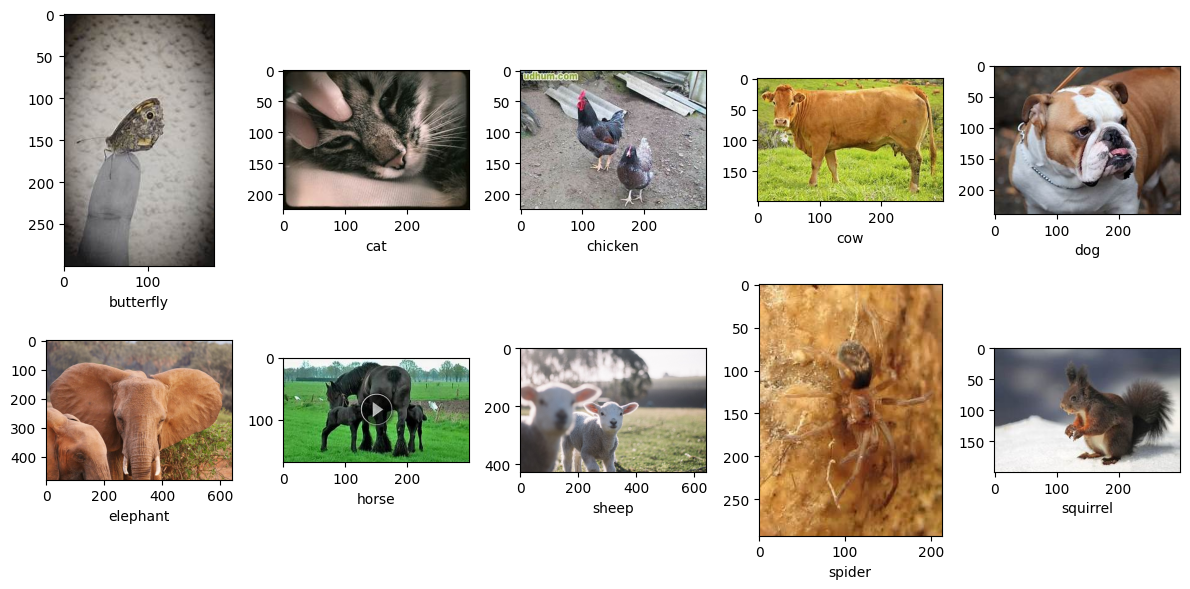

In [23]:
sample_df = df.groupby('label').first().reset_index()
_, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(sample_df.iterrows()):
    filename =  row["filepath"] # type: ignore
    category =  row["label"] # type: ignore
    img = Image.open(filename).convert("RGB")
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_xlabel(category)
plt.tight_layout()
plt.show()

# Label encoding

In [24]:
labelEncoding = {label: str(idx) for idx, label in enumerate(df['label'].unique())}
df['label_encoded'] = df['label'].map(labelEncoding)
df.groupby('label_encoded').first().head(df['label'].nunique())

,label,filepath
label_encoded,,
0,horse,./dataset/raw-img/cavallo/OIP-w_u9gdSBzD9Lowb8...
1,dog,./dataset/raw-img/cane/OIP-Z1osYjDXBcmia1smPit...
2,chicken,./dataset/raw-img/gallina/OIP-CL4IgKqQ1Agot40_...
3,sheep,./dataset/raw-img/pecora/eb33b1092cf4043ed1584...
4,spider,./dataset/raw-img/ragno/OIP-vTYm2k1cVvkiMlLOxy...
5,cow,./dataset/raw-img/mucca/OIP-5KXJ70e6l9qwDzE2pS...
6,cat,./dataset/raw-img/gatto/1166.jpeg
7,butterfly,./dataset/raw-img/farfalla/OIP-1GLDT_vfdLFEcWB...
8,squirrel,./dataset/raw-img/scoiattolo/OIP-CV4rEZnSkXLIG...


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          26179 non-null  object
 1   filepath       26179 non-null  object
 2   label_encoded  26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


# Splitting data

In [26]:
def split_data(df: pd.DataFrame, test_size: float, val_size: float, random_state: int):
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label_encoded'],
        random_state=random_state
    )

    val_relative_size = val_size / (1 - test_size)

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df['label_encoded'],
        random_state=random_state
    )

    train_x = train_df['filepath']
    train_y = train_df['label_encoded']

    val_x = val_df['filepath']
    val_y = val_df['label_encoded']

    test_x = test_df['filepath']
    test_y = test_df['label_encoded']

    return train_x, train_y, val_x, val_y, test_x, test_y

In [27]:
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df, test_size=0.3, val_size=0.2, random_state=880055535)

# Pipeline transformations

In this part we want to find mean / std for our dataset for normalization

Resize images to 128x128 because from eda we know that are mean size of images is around 320*252, so resizing to 128x128 will not lose much information but will speed up training process significantly. Also images are have good quality so downsizing is ok.

In [ ]:
from image_dataset import ImageDataset
tr = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

dataset = ImageDataset(train_x, train_y, transform=tr)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

mean = 0.
std = 0.
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images
print(f"Mean: {mean}")
print(f"Std: {std}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Mean: tensor([0.5185, 0.5014, 0.4133])
Std: tensor([0.2081, 0.2077, 0.2097])


now we can add normaliser for all pipelines

In [29]:
tr_norm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_dataset = ImageDataset(val_x, val_y, transform=tr)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

train_dataset_norm = ImageDataset(val_x, val_y, transform=tr_norm)
train_loader_norm = DataLoader(train_dataset_norm, batch_size=64, shuffle=True, num_workers=2)

test_dataset = ImageDataset(test_x, test_y, transform=tr_norm)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: T

In [31]:
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [32]:
def predict_all(model, loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            preds.extend(p.cpu().numpy())
    return np.array(preds)

In [33]:
num_classes = len(labelEncoding)

In [ ]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module, train_loader: DataLoader, num_epochs=5):
    loss_vals=  []
    for epoch in range(num_epochs):
        loss = 0
        epoch_loss= []
        for _, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()

            epoch_loss.append(loss.item())
            optimizer.step()

        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print(epoch, "Current Loss:", loss)
    return loss_vals

def evaluate(loader, model):
    """
        @returns: (all_preds, all_targets)
    """
    all_preds = []
    all_targets = []
    
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, pred = scores.max(1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    return all_preds, all_targets


Adam was used because nowadays it is mostly used optimizer. It combines RMSProp with momentum and bias correction, which adjusts the deviations at the start of the algorithm and speeds up the convergence

## Training the model for check the difference between pipelines with and without normalization

In [35]:
model_regular = SimpleCNN(num_classes).to(device)
loss_vals_regular = train(model_regular, torch.optim.Adam(model_regular.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
model_norm = SimpleCNN(num_classes).to(device)
loss_vals_norm = train(model_norm, torch.optim.Adam(model_norm.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader_norm)

0 Current Loss: tensor(2.0091, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(2.0419, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.7210, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.3288, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.3757, device='cuda:0', grad_fn=<NllLossBackward0>)
0 Current Loss: tensor(2.2726, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(2.2797, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9487, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6151, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.5807, device='cuda:0', grad_fn=<NllLossBackward0>)


after we train our model we can evaluate it on train and test datasets, so we can check if there any difference in accuracy between pipelines with and without normalization

<Axes: >

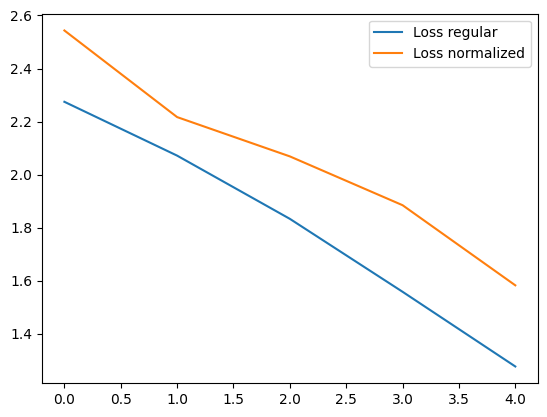

In [36]:
sns.lineplot(x=range(len(loss_vals_regular)), y=loss_vals_regular, label="Loss regular")
sns.lineplot(x=range(len(loss_vals_norm)), y=loss_vals_norm, label="Loss normalized")

## Evaluating the model for both pipelines

### Pipeline without normalization

In [ ]:
train_pred_regular, train_target_regular = evaluate(train_loader, model_regular)
test_pred_regular, test_target_regular = evaluate(test_loader, model_regular)
classification_report(train_target_regular, train_pred_regular)
classification_report(test_target_regular, test_pred_regular)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: tensor(67.3606, device='cuda:0') %
Accuracy: tensor(11.7265, device='cuda:0') %


### Pipeline with normalization

In [ ]:
train_pred_norm, train_target_norm = evaluate(train_loader, model_norm)
test_pred_norm, test_target_norm = evaluate(test_loader, model_norm)

Accuracy: tensor(21.3140, device='cuda:0') %
Accuracy: tensor(41.3802, device='cuda:0') %


In [ ]:
classification_report(train_target_norm, train_pred_norm)

In [ ]:
classification_report(test_target_norm, test_pred_norm)

Conclusion on the experiments:
Even if normalization is on graphs shows more Loss then without normalization, accuracy for test is more higher with normalization then without it. So normalization helps our model to generalize better on unseen data. Just we need to add more epochs

# Wanddb configuration

In [ ]:
# os.environ['WANDB_API_KEY'] = ""
api_key = os.environ.get('WANDB_API_KEY')
if api_key:
    wandb.login(key=api_key)
    print("Logged in to W&B successfully.")
else:
    raise ValueError("W&B API key not found in environment variables.")

ValueError: W&B API key not found in environment variables.

# Augmentation

For augumentations we will add to transformation with normalisation some augumentations such as random resize, crop, random horizontal flip, random color change, random rotation


## Configurations

In [ ]:
train_transforms = {
    "baseline": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "light": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "medium": transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "hard": transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
}

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

## Testing all configurations

In [ ]:
# for transform_name, transform in train_transforms.items():
#     print(f"Training with {transform_name} augmentation")
#     run = wandb.init(project="animal_classification", name=f"augmentation_{transform_name}")
#     train_dataset = ImageDataset(train_x, train_y, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

#     model = SimpleCNN(num_classes).to(device)
#     loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
#     sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss {transform_name}")
#     print(f"Evaluating model trained with {transform_name} augmentation")
#     test_dataset = ImageDataset(test_x, test_y, transform=eval_transform)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
#     pred, target = evaluate(test_loader, model)
#     run.log({
#             "train_loss": loss_vals, 
#             "transform": transform_name, 
#             "test_accuracy": accuracy_score(target, pred),
#             "test_precision": precision_score(target, pred, average='weighted'),
#             "test_recall": recall_score(target, pred, average='weighted'),
#             "test_f1": f1_score(target, pred, average='weighted')
#         })
#     run.finish()

Conclusion on augumentations:
After testing different augumentations we can see that best results shows combination of light version is the best one. 

# Random params search

## Baseline transforms

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

model = SimpleCNN(num_classes).to(device)
loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss light augmentation")

In [ ]:
pred, target = evaluate(test_loader, model)
classification_report(target, pred)

## Finding best augumentation parameters

In [26]:
import itertools

config_map_variations = {
    "random_resized" : [(64, 64), (96, 96), (128, 128),(192, 192), (256, 256)],
    "random_horizontal_flip" : [0.1, 0.3, 0.5, 0.7],
}
keys = list(config_map_variations.keys())
values = list(config_map_variations.values())
combinations = list(itertools.product(*values))

transform_configs = []
for combo in combinations:
    config = dict(zip(keys, combo))
    transform_configs.append(config)
transform_configs

[{'random_resized': (64, 64), 'random_horizontal_flip': 0.1},
 {'random_resized': (64, 64), 'random_horizontal_flip': 0.3},
 {'random_resized': (64, 64), 'random_horizontal_flip': 0.5},
 {'random_resized': (64, 64), 'random_horizontal_flip': 0.7},
 {'random_resized': (96, 96), 'random_horizontal_flip': 0.1},
 {'random_resized': (96, 96), 'random_horizontal_flip': 0.3},
 {'random_resized': (96, 96), 'random_horizontal_flip': 0.5},
 {'random_resized': (96, 96), 'random_horizontal_flip': 0.7},
 {'random_resized': (128, 128), 'random_horizontal_flip': 0.1},
 {'random_resized': (128, 128), 'random_horizontal_flip': 0.3},
 {'random_resized': (128, 128), 'random_horizontal_flip': 0.5},
 {'random_resized': (128, 128), 'random_horizontal_flip': 0.7},
 {'random_resized': (192, 192), 'random_horizontal_flip': 0.1},
 {'random_resized': (192, 192), 'random_horizontal_flip': 0.3},
 {'random_resized': (192, 192), 'random_horizontal_flip': 0.5},
 {'random_resized': (192, 192), 'random_horizontal_flip'

In [ ]:
for item in transform_configs:
    run = wandb.init(project="animal_classification", name=f"rand_search_resized_{item['random_resized']}_flip_{item['random_horizontal_flip']}")
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(item['random_resized'], scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=item['random_horizontal_flip']),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    train_dataset = ImageDataset(train_x, train_y, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    model = SimpleCNN(num_classes).to(device)
    loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
    sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss resized {item['random_resized']} flip {item['random_horizontal_flip']}")
    pred, target = evaluate(test_loader, model)
    run.log({
            "train_loss": loss_vals, 
            "random_resized": item['random_resized'], 
            "random_horizontal_flip": item['random_horizontal_flip'],
            "test_accuracy": accuracy_score(target, pred),
            "test_precision": precision_score(target, pred, average='weighted'),
            "test_recall": recall_score(target, pred, average='weighted'),
            "test_f1": f1_score(target, pred, average='weighted')
        })
    run.finish()